In [114]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import splitfolders
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import pathlib

## Data Collecting

 Bagi data :
 - Train
 - Val
 - Test

In [2]:
splitfolders.ratio('HijabDataset/','Data',ratio=(0.7,0.2,0.1))

Copying files: 10000 files [01:01, 162.77 files/s]


In [22]:
trainPath = 'Data/train/'
valPath = 'Data/val/'
testPath = 'Data/test/'

**Read Data**

In [23]:
train =tf.keras.utils.image_dataset_from_directory(trainPath)
val =tf.keras.utils.image_dataset_from_directory(valPath)
test =tf.keras.utils.image_dataset_from_directory(testPath)

Found 7000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Data Preprocessing

In [24]:
def random_brightness(image,label):
    return tf.image.random_brightness(image, max_delta=0.5),label

def random_flip(image,label):
    return tf.image.random_flip_left_right(image),label

def resize(image,label):
    return tf.image.resize(image,[150,150]),label

In [25]:
train = train.map(random_brightness).map(random_flip).shuffle(20).map(resize)

test = test.map(resize)

val = val.map(resize)

## Visualisasi Data

In [26]:
class_names = os.listdir('HijabDataset/')
class_names

['hijab', 'nonhijab']

In [121]:
class_size = []

for i in os.listdir(trainPath):
    image_count = 0
    data_dir = pathlib.Path(trainPath + '/' +i)
    image_count = len(os.listdir(data_dir))
    class_size.append(image_count)

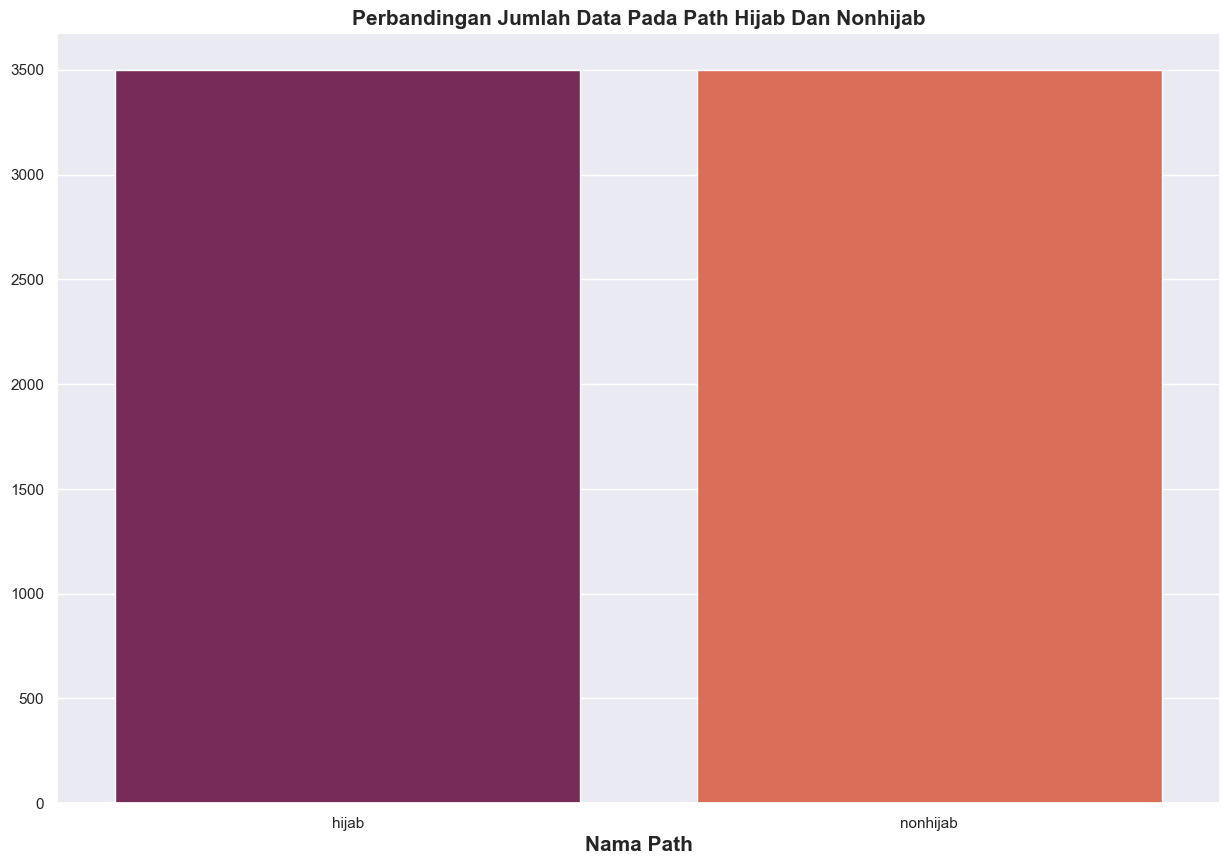

In [122]:
sns.set_theme()
plt.figure(figsize=(15,10))

sns.barplot(x=class_names,y=class_size,palette='rocket')
plt.title("Perbandingan Jumlah Data Pada Path Hijab Dan Nonhijab",fontfamily='arial',fontsize=15, fontweight='bold')
plt.xlabel('Nama Path',fontfamily='arial',fontsize=15, fontweight='bold')
plt.show()

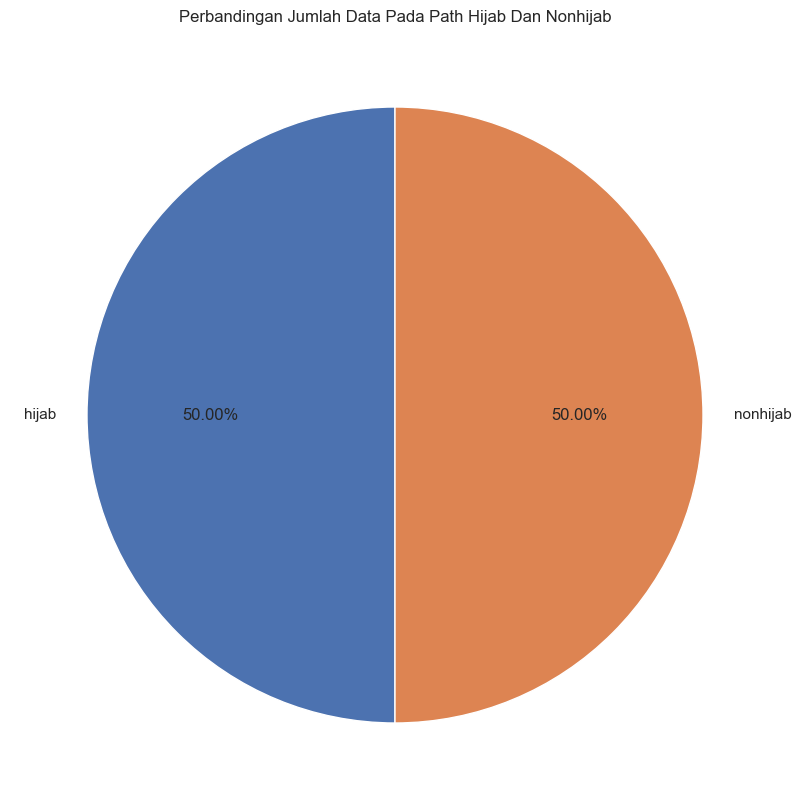

In [113]:
plt.figure(figsize=(10,10))
plt.pie(class_size, labels=class_names,startangle=90,autopct='%.2f%%')
plt.title('Perbandingan Jumlah Data Pada Path Hijab Dan Nonhijab')
plt.show()

**Preview Data**

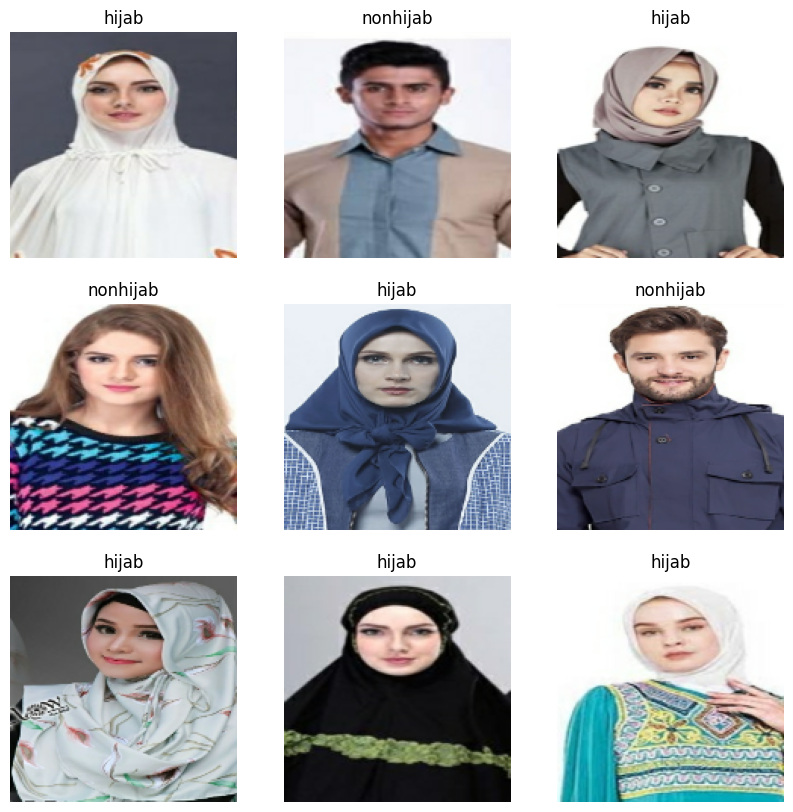

In [27]:
# data visualization
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')


### Bulid the Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [32]:
#Implementasi CNN
model = Sequential([
    #Input Layer, kita menggunakan size sesuai dengan size data kita yaiyu 150 x 150
    layers.Conv2D(16,3, activation='relu', input_shape=(150,150,3)),
    
    #Hidden Layer, untuk pencarian pola dari data kita
    layers.MaxPool2D(),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16,3, activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    
    #Output Layer, hasil klasifikasi dari hidden layer
    layers.Dense(1,activation='sigmoid')
])

In [34]:
#untuk menentukan optimizer, disini kami menggunakan adam dan fungsi loss menggunakan binary_crossentropy, 
#lalu kami juga menggunakan accuracy pada tampilan hasil epoch
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# untuk menampilkan layer model CNN
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

### Train the Model

In [38]:
# untuk memberhentikan epoch jika val_accuracy tidak ada perkembangan selama 5 epoch kedepan
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
)

In [39]:
#melakukan pencarian pola pada gambar pada model.fit
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[early])

Epoch 1/15
219/219 [==============================] - 88s 390ms/step - loss: 1.4252 - accuracy: 0.8359 - val_loss: 0.2133 - val_accuracy: 0.9150
Epoch 2/15
219/219 [==============================] - 84s 378ms/step - loss: 0.1217 - accuracy: 0.9537 - val_loss: 0.1445 - val_accuracy: 0.9510
Epoch 3/15
219/219 [==============================] - 85s 379ms/step - loss: 0.0785 - accuracy: 0.9707 - val_loss: 0.1285 - val_accuracy: 0.9560
Epoch 4/15
219/219 [==============================] - 79s 353ms/step - loss: 0.0516 - accuracy: 0.9829 - val_loss: 0.1129 - val_accuracy: 0.9670
Epoch 5/15
219/219 [==============================] - 80s 356ms/step - loss: 0.0444 - accuracy: 0.9854 - val_loss: 0.0811 - val_accuracy: 0.9765
Epoch 6/15
219/219 [==============================] - 80s 358ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.0800 - val_accuracy: 0.9760
Epoch 7/15
219/219 [==============================] - 84s 374ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 0.0891 - val_ac

## Evaluasi

In [42]:
#menampilkan hasil evaluasi dari test set
hasil = model.evaluate(test,verbose=0)
print('Loss :', hasil[0])
print('Accuracy :', hasil[1])

Loss : 0.056042734533548355
Accuracy : 0.9879999756813049


## Hasil Train Model

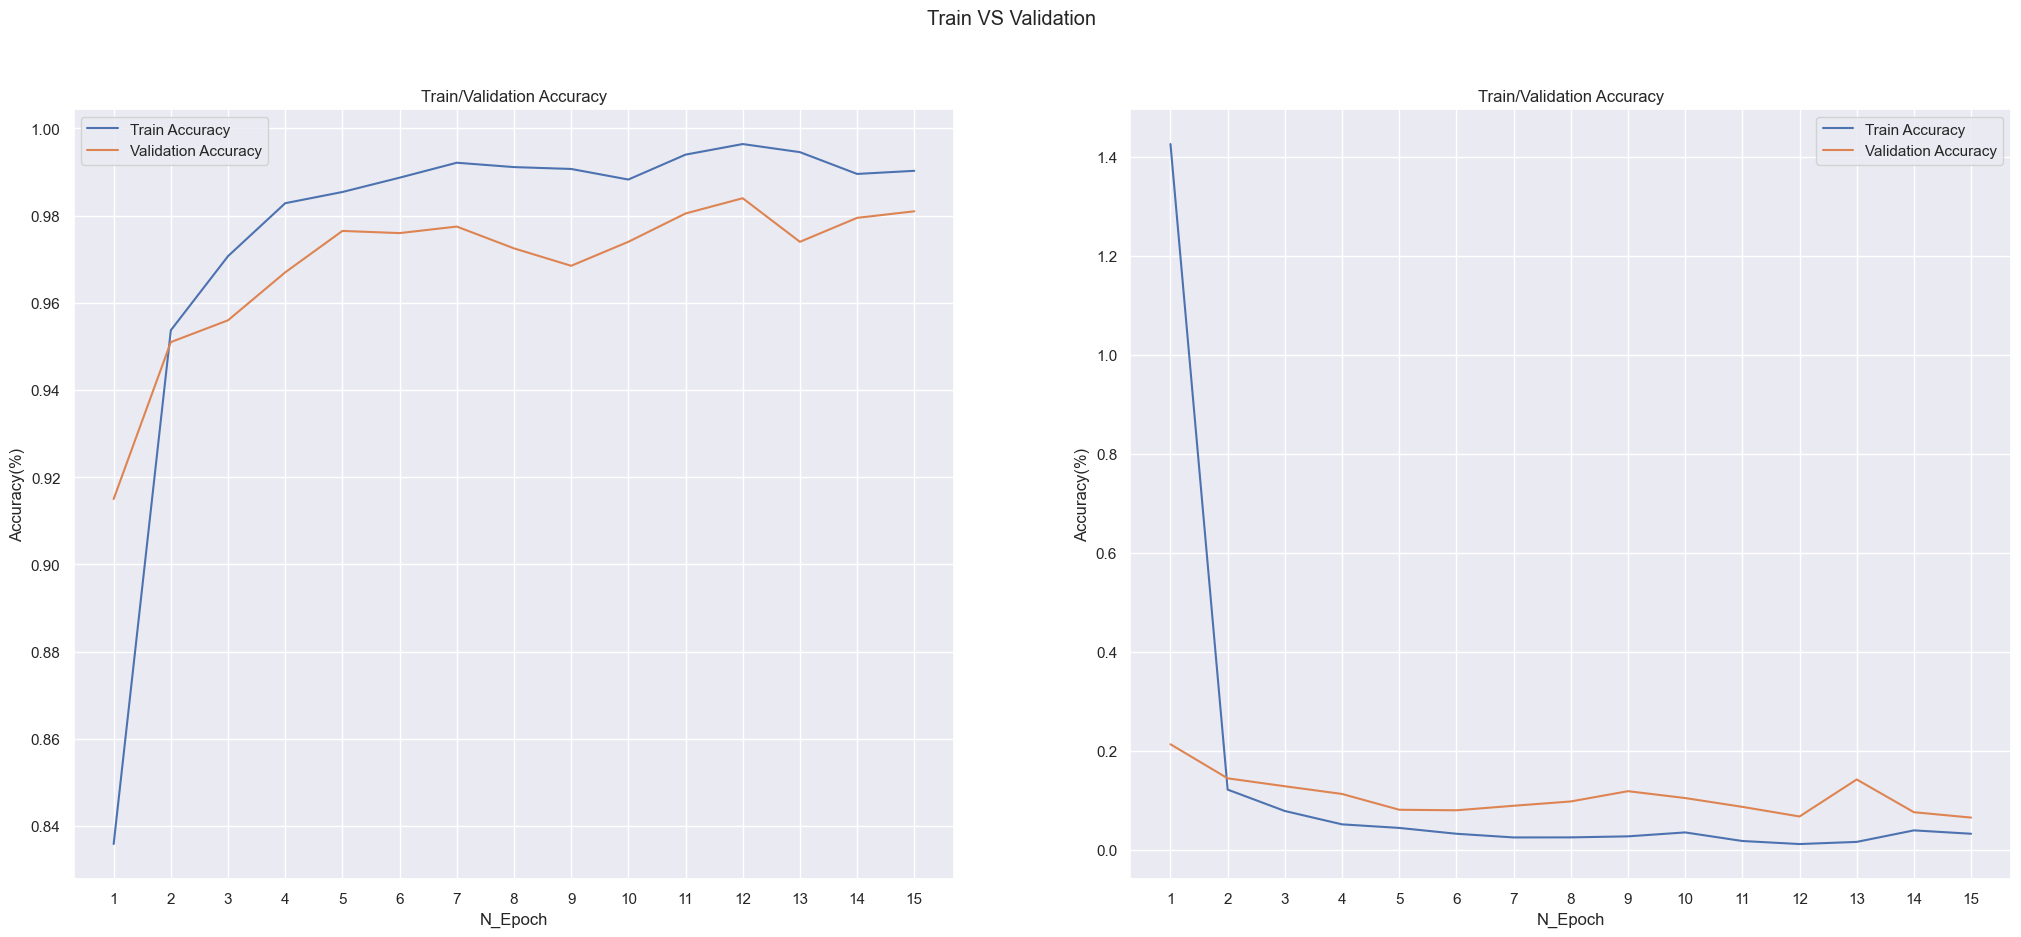

In [44]:
#menampilkan hasil akurasi perkembangan validation dan training dari epoch 1-15
sns.set_theme()
epoch = [i+1 for i in range(15)]


plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epoch,y = hist.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epoch,y = hist.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epoch)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")


#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epoch,y = hist.history['loss'],label ='Train Accuracy')
sns.lineplot(x=epoch,y = hist.history['val_loss'],label ='Validation Accuracy')

plt.xticks(epoch)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")

plt.show()

### Test the Model

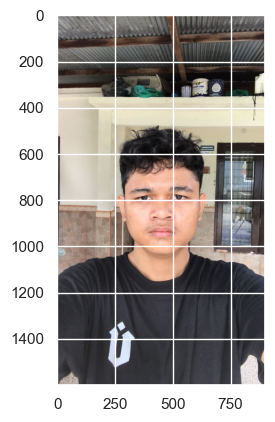

In [58]:
#masukkan gambar yang ingin di tes 
hijab_image = cv2.imread('D:/Download/erman.jpg')
plt.imshow(cv2.cvtColor(hijab_image,cv2.COLOR_BGR2RGB))
plt.show()

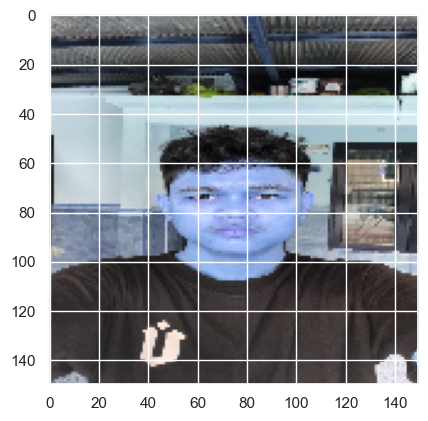

In [59]:
# melakukan resize gambar menjadi 150 x 150
resized_hijab_image = tf.image.resize(hijab_image, (150,150))
plt.imshow(resized_hijab_image.numpy().astype(int))
plt.show()

In [60]:
#menerapkan model pada gambar yang ingin di prediksi
y_pred = model.predict(np.expand_dims(resized_hijab_image, 0))
     
y_pred

1/1 [==============================] - 0s 32ms/step


array([[0.99999434]], dtype=float32)

In [62]:
if y_pred > 0.5: 
    print(f'Diprediksi Tidak Menggunakan Hijab')
else:
    print(f'Diprediksi Menggunakan Hijab')

Diprediksi Tidak Menggunakan Hijab


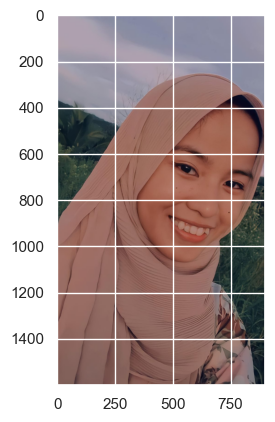

In [63]:
#masukkan gambar yang ingin di tes 
wthout_hijab_image = cv2.imread('D:/Download/heraa.jpg')
plt.imshow(cv2.cvtColor(wthout_hijab_image,cv2.COLOR_BGR2RGB))
plt.show()

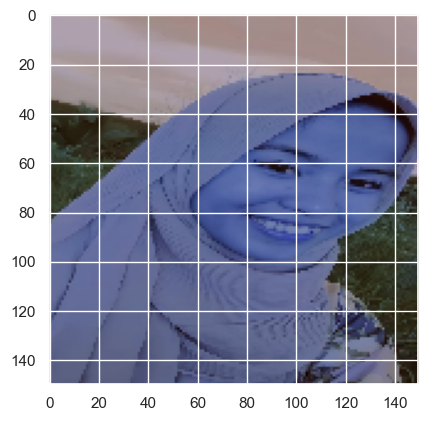

In [64]:
# melakukan resize gambar menjadi 150 x 150
resized_wthout_hijab_image = tf.image.resize(wthout_hijab_image, (150,150))
plt.imshow(resized_wthout_hijab_image.numpy().astype(int))
plt.show()

In [65]:
#menerapkan model pada gambar yang ingin di prediksi
y_pred = model.predict(np.expand_dims(resized_wthout_hijab_image, 0))

y_pred

1/1 [==============================] - 0s 32ms/step


array([[0.01544834]], dtype=float32)

In [66]:
if y_pred > 0.5: 
    print(f'Diprediksi Tidak Menggunakan Hijab')
else:
    print(f'Diprediksi Menggunakan Hijab')

Diprediksi Menggunakan Hijab


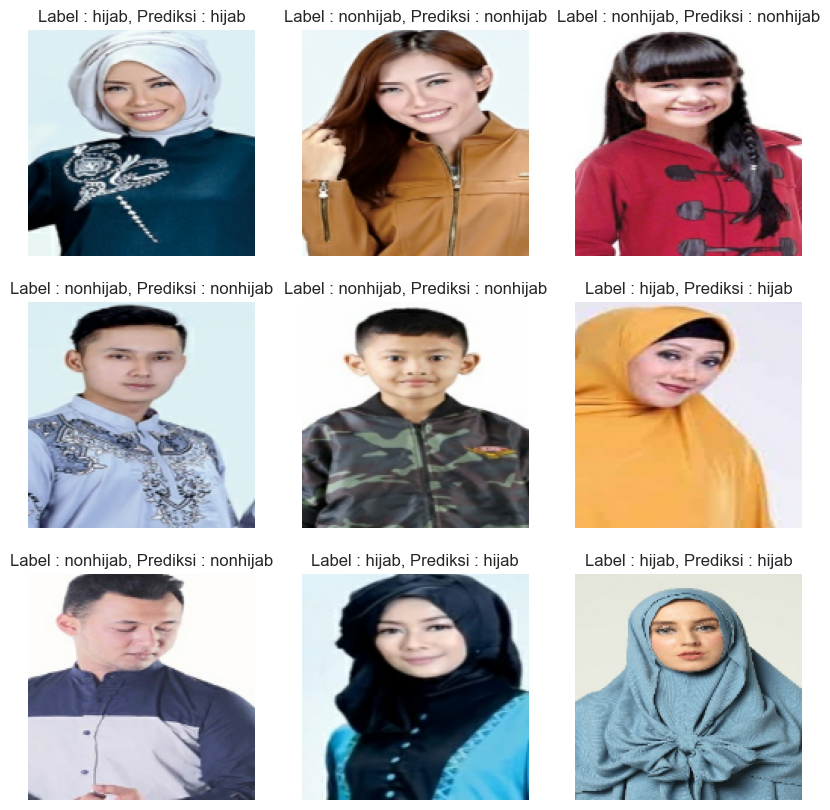

In [67]:
# membandingkan data aktual dengan data yang diprediksi dengan model
plt.figure(figsize=(10, 10))
for images, labels in test.take(1):
  for i in range(9):
    hasil = 0
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    y_pred = model.predict(np.expand_dims(images[i], 0),verbose=0)
    
    if y_pred > 0.5: 
        hasil = 1
    else:
        hasil = 0
    plt.title(f'Label : {class_names[labels[i]]}, Prediksi : {class_names[hasil]}')
    plt.axis('off')


## Confusion Matrix

In [102]:
# membandingkan prediksi yang benar dan prediksi yang salah
test_pred = model.predict(test)
test_labels1 = np.concatenate([y for x, y in test], axis=0)
test_pred = np.round(test_pred).tolist()
test_pred = np.array(test_pred,dtype=np.int64)

32/32 [==============================] - 4s 110ms/step


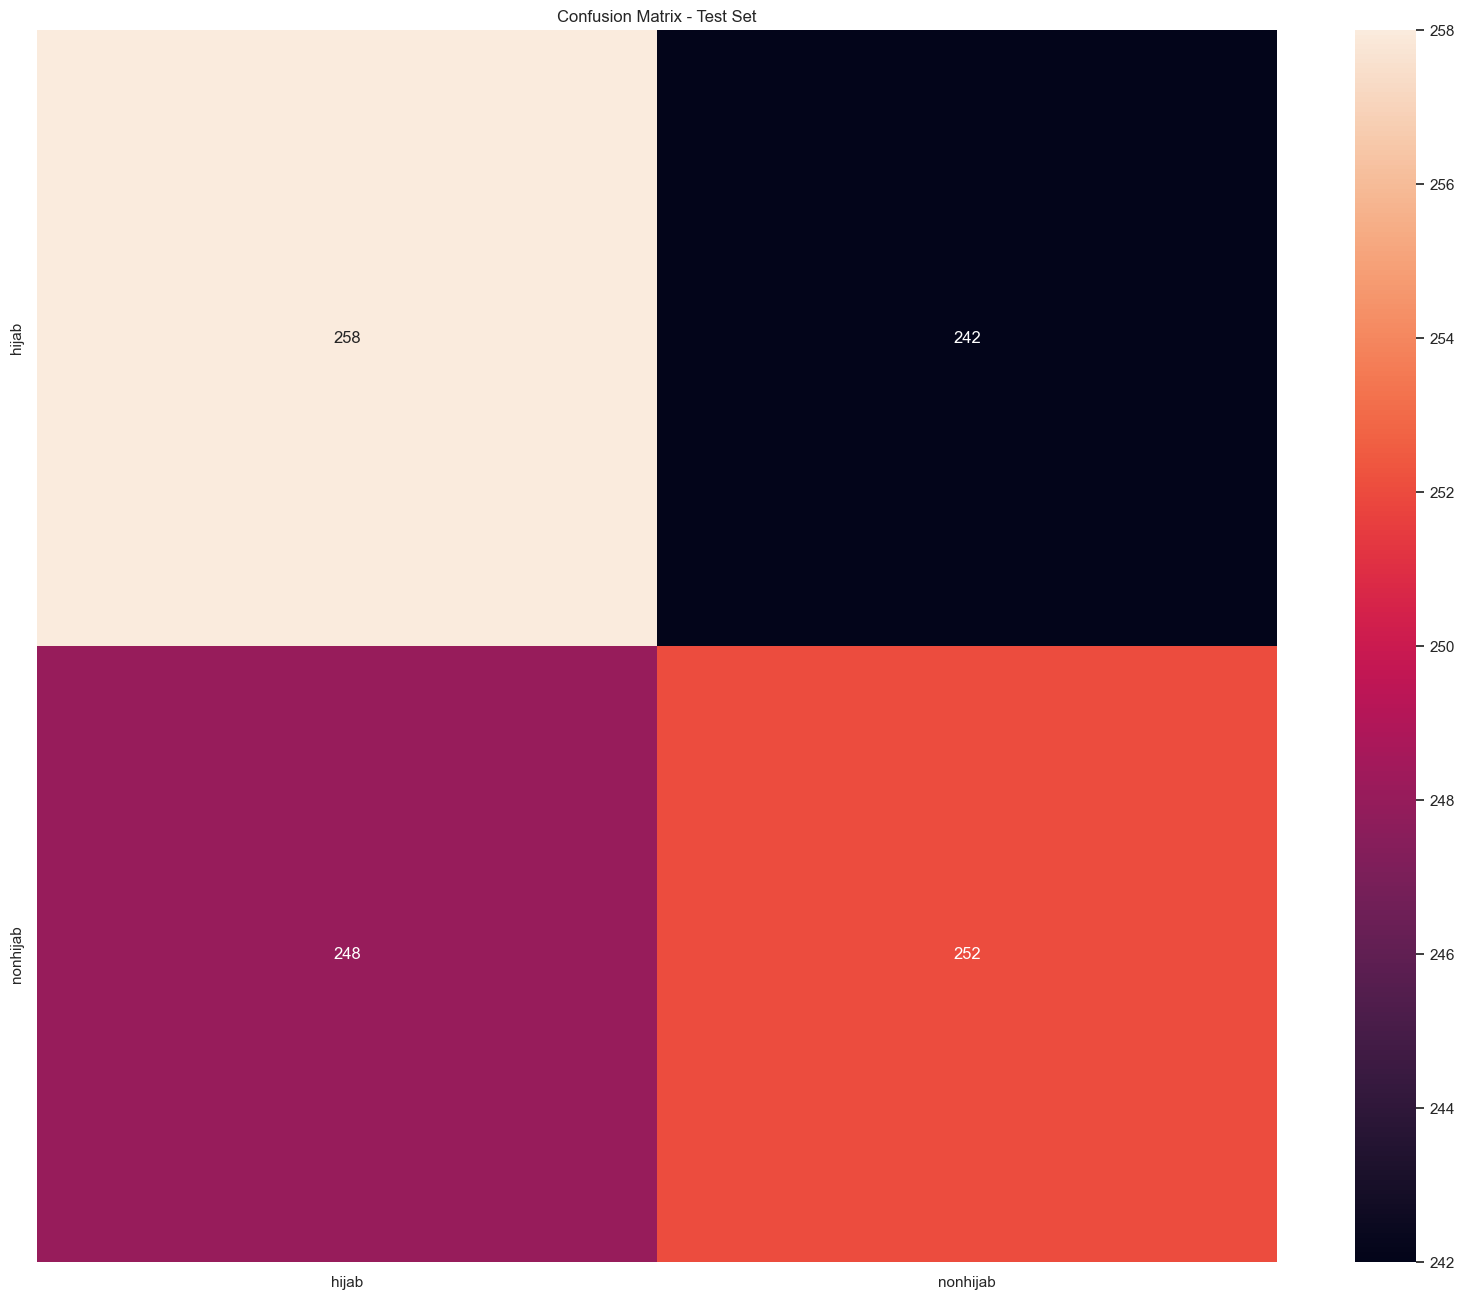

In [103]:
plt.figure(figsize=(20, 16))
cm = confusion_matrix(test_labels1,test_pred)

sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
plt.title("Confusion Matrix - Test Set")
plt.show()

## Classification Report

In [115]:
# menampilkan matrix pengukuran lain seperti precision, recall, f1-score
print('Classification Report')
print(classification_report(test_labels1, test_pred, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       hijab       0.51      0.52      0.51       500
    nonhijab       0.51      0.50      0.51       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



### Save the Model

In [119]:
from tensorflow.keras.models import load_model
model.save('classifier model.h5')

In [120]:
new_model = load_model('classifier model.h5')
new_model.predict(np.expand_dims(resized_wthout_hijab_image, 0))

1/1 [==============================] - 0s 95ms/step


array([[0.01544834]], dtype=float32)